# Question 1 : Buffons Matches

### Basic code structure

- *Class* : `Match` -> Denotes the data associated with a match
    - `plot_match(ax : Axes)` -> Draws the match
    - `destroy(ax : Axes)` -> To remove the match from the plot after a certain amount matches are there
- *Class* : `Board` -> Denotes the data associated with lines drawn on the board
    - `plot_board(ax : Axes)` -> Draws the board
    - `is_touching(match : Match)`  -> Checks if the passes match is touching any lines on the board
- *Func* : `buffons_matches(L : int, d : int)` -> Works as specified
- *Helper Func* : `reset_vars()` -> Resets variables if creating multiple gifs at a time
- *Helper Func* : `loop()` -> Animation loop
 
### Output

- The output of `buffons_matches(L : int, d : int)` is saved as a gif to the cwd
 
.

In [1]:
# Importing Libraries

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from matplotlib.patches import Circle

In [3]:
# Global Variables
x_min, x_max = 0, 10
y_min, y_max = 0, 10
no_of_matches_touched = 0
total_matches = 0
ratio = 0 # To store the ratio of (total_no_of_matches)/(no_of_matches_touching_line)
matches = [] # Stores the Match objects
ax = None # MatplotLib Axes Object
board = None # Stores the Board

# Variables specific to creating the gif
interval = 10 # Time interval between each frame in the gif
frames = 2000 # Each frame corresponds to a match
show_all_matches = True 
matches_threshold = 100 # The maximum matches to be displayed in the gif at a time when `show_all_matches == False`

# Classes

# Describes a match
class Match:
    L = 1
    
    def __init__(self, x=None, y=None, theta=None, L=None): 
        '''
        We need 4 values to describe a match. (x, y, theta, L)
        - x, y -> Coordinates
        - theta -> Angle made with the x-axis
        - L -> Length of the match

        L defaults to Match.L if not provided. Rest of the variables are randomly selected if not provided
        '''
        
        self.x = x if x else np.random.uniform(x_min, x_max)
        self.y = y if y else np.random.uniform(y_min , y_max)
        self.theta = theta if theta else np.radians(np.random.uniform(0, 360))
        self.L = Match.L if L is None else L
        self.match_head_radius = self.L / 20 if self.L / 20 < y_max / 100 else y_max / 100

        self.match_parts = []

    # Plots the match. Based on whether touching a line, can have another color
    def plot_match(self, ax, on_line = False):
        lby2_sin_theta = np.sin(self.theta) * (self.L / 2)
        lby2_cos_theta = np.cos(self.theta) * (self.L / 2)

        # Plots the wooden part
        line, = ax.plot([self.x - lby2_cos_theta, self.x + lby2_cos_theta],
                [self.y - lby2_sin_theta, self.y + lby2_sin_theta], 
                color=('b' if on_line else 'y'), linewidth=3, solid_capstyle='round', zorder = 2)

        # Plots the head
        head = Circle((self.x + lby2_cos_theta, self.y + lby2_sin_theta), self.match_head_radius, color = ('g' if on_line else 'r'), zorder = 3)
        ax.add_patch(head)

        self.match_parts = [head, line]

    def destroy(self, ax):
        self.match_parts[0].remove()
        self.match_parts[1].remove()

        self.match_parts = []


# This class describes the board
class Board:
    '''
    Stores the y_values associated with each Line on the Board
    '''
    def __init__(self, d=1):
        self.d = d
        self.lines = [self.d*i for i in range(0, 16)] # y_max should be perfectly divided by self.d [IMP for acccuracy]

    # Draws each line
    def plot_board(self, ax):
        for line_y in self.lines:
            ax.plot([x_min, x_max], [line_y, line_y], color='k')

    # Checks if touching a match
    def is_touching(self, match) -> bool:
        lby2_sin_theta = np.sin(match.theta) * (match.L / 2)
        y = match.y
        
        for line_y in self.lines:
            # If a match is tocuhing condition
            # The y coordinate of the line has to lie between the y coordinates of the tips of the match. That is the logic
            if (line_y < y + lby2_sin_theta and line_y > y - lby2_sin_theta) or (line_y < y - lby2_sin_theta and line_y > y + lby2_sin_theta):
                return True

        return False

In [5]:
# Helper Functions

def reset_vars():
    global no_of_matches_touched, total_matches, ratio, matches, ax, board
    no_of_matches_touched = 0
    total_matches = 0
    ratio = 0 # To store the ratio of (total_no_of_matches)/(no_of_matches_touching_line)
    matches = []

    return loop(0)


def loop(frame):
    global no_of_matches_touched, ratio, total_matches
    total_matches += 1

    # Finds and writes the ratio into the plot
    ratio = ((total_matches) / no_of_matches_touched if no_of_matches_touched else 0)
    ax.set_title(f"No of matches: {total_matches}, Crossed: {no_of_matches_touched}, Ratio value: {ratio:2.5f}")

    # Creates new random match
    new_match = Match()
    matches.append(new_match)

    # If too many matches are there, to reduce lag, removing previous matches (Comment out to avoid)
    if not show_all_matches and len(matches) > matches_threshold:
        matches[0].destroy(ax)
        del matches[0]

    # Checking if favorable case
    touching = board.is_touching(new_match)
    no_of_matches_touched += int(touching)

    # Plotting match
    new_match.plot_match(ax, touching)
    
    return ax.artists + ax.lines

In [12]:
def buffons_matches(L : int, d : int):
    global ax, board, ratio, x_max, y_max
    
    if (L <= 0 or d <= 0):
        raise ValueError("Invalid values for L or d")
    Match.L = L

    # Just an aribatary no lines on the board. Here, 15
    # If the below is not taken care of, errors will occur in the final ans because of how the experiment is done
    x_max = y_max = 15 * d

    fig, ax = plt.subplots(figsize=(8, 6))
    ax.set(xlim=(x_min, x_max), ylim=(y_min, y_max))

    # Init Board
    board = Board(d)
    board.plot_board(ax)

    # Creates Anim
    ani = animation.FuncAnimation(
        fig, 
        loop, 
        interval = interval,
        blit = True,  # Enable blitting for smoother animation
        cache_frame_data = False,
        frames = frames,
        init_func = reset_vars
    )
    
    ani.save("buffons_matches.gif", writer="pillow") # Saves the gif to cwd
    plt.show() # Shows the last frame of the simulation
    print(f"π estimate : {ratio * ((2 * L) / d)}")
    return ratio * # Returns the ratio

### Result

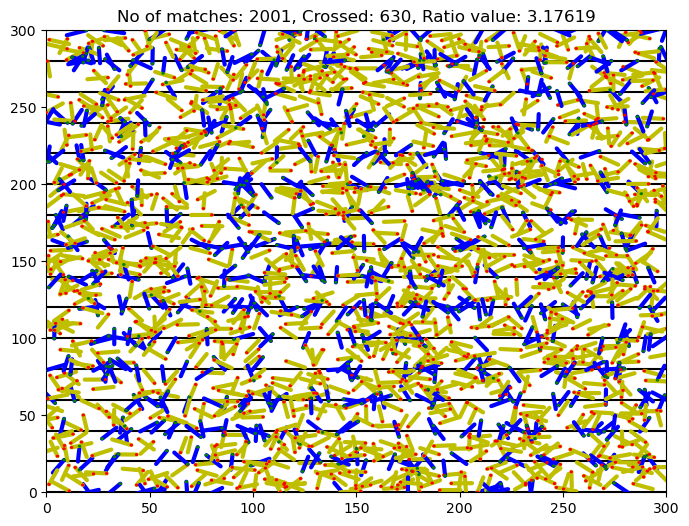

π estimate : 3.176190476190476


3.176190476190476

In [44]:
# Based on the no of frames/matches, it will take time to return an output 
# Expect 100MB gif for 2000 frames
buffons_matches(10, 20)

# Question 2 : Birthday Problem

### Basic code structure

- Func : `birthday_probability(n : int, k : int) -> float` -> Returns Probability that atleast k people have same birthday in n people
- Func : `find_min_n(prb_greater_than, n_max = 365, n_min = 2)` -> Finds the minimum no of people required to atleast have a min probability of `prb_greater_than`
- Func : `given_func(x)` -> Represents $1 - e^{(-\frac{x^2}{730})}$

In [16]:
# Importing necessary libraries

import numpy as np
import matplotlib.pyplot as plt

### SubQuestion 2

In [21]:
def birthday_probability(n : int, k : int):
    trials = 10000 # The more, the more accurate the probability, the more time it takes to estimate
    count = 0 # Counts favourable cases
    
    for i in range(trials):
        freq = {} # Has the frequency of each number
        arr = np.random.randint(0, 365, n) # Each num in the array can be taken to represent a date in a 365 day year
        # Counting frequencies
        for num in arr:
            try:
                freq[num] += 1
            except:
                freq[num] = 1
                
        if (sorted(freq.values())[-1] >= k): count += 1 # If highest freq > k => count++ # Valid case
            
    return count / trials # Return Probability

### SubQuestion 1

In [24]:
# Implemented based on the knowledge that as n inc -> prob inc (Binary search)
def find_min_n(prb_greater_than, n_max = 365, n_min = 2):
    if (n_max - n_min == 1): return n_max
    
    if n_max > 365:
        n_max = 365
    if n_min < 2:
        n_min = 2
    
    prb_mid = birthday_probability((n_max + n_min) // 2, 2)
    print(f"For n: {(n_max + n_min) // 2} -> Approx Probability: {prb_mid:.4f}")

    if (prb_greater_than > prb_mid):
        return find_min_n(prb_greater_than, n_max, (n_max + n_min)//2)
    elif (prb_greater_than < prb_mid):
        return find_min_n(prb_greater_than, (n_max + n_min)//2, n_min)

In [26]:
find_min_n(0.7)

For n: 183 -> Approx Probability: 1.0000
For n: 92 -> Approx Probability: 1.0000
For n: 47 -> Approx Probability: 0.9546
For n: 24 -> Approx Probability: 0.5471
For n: 35 -> Approx Probability: 0.8191
For n: 29 -> Approx Probability: 0.6771
For n: 32 -> Approx Probability: 0.7564
For n: 30 -> Approx Probability: 0.7086


30

### SubQuestion 3

In [32]:
# The provided function
def given_func(x):
    return 1 - np.exp(-(x*x)/730)

In [34]:
x = np.linspace(2, 60, 59, dtype=int)
y1 = [birthday_probability(x_i, 2) for x_i in x]
y2 = given_func(x)

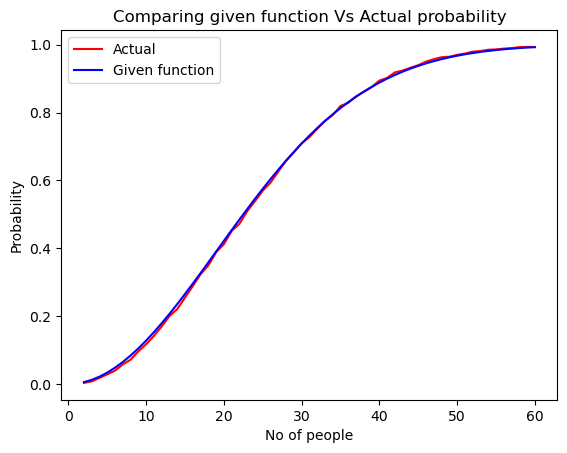

In [35]:
# Plotting
plt.plot(x, y1, color='r', label="Actual")
plt.plot(x, y2, color='b', label="Given function")
plt.title("Comparing given function Vs Actual probability")
plt.xlabel("No of people")
plt.ylabel("Probability")
plt.legend()
plt.show()

## Why are the graphs so similar?

We know that $$e^x = 1 + x + \frac{x^2}{2!} ...$$
Which implies (given $|x| << 1$)$$e^x \approx 1 + x$$

We know that the probability that when atleast two people have the same birthday amongst n people is $$1 - \frac{^{365}P_n}{365^n}$$
This can be simplified to $$1 - \left(1 - \frac{1}{365}\right)\left(1 - \frac{2}{365}\right)...\left(1 - \frac{n-1}{365}\right)$$
Which, on considering the above approximation ($e^x \approx 1 + x$) turns to $$1 - e^{-\frac{1}{365}}.e^{-\frac{2}{365}}...e^{-\frac{n-1}{365}}$$
Which can be simplified to $$1 - e^{-\frac{n^2}{730}}$$